In [1]:
import ufl
import matplotlib.pyplot as plt
import time
import numpy as np
from dolfin import *
import matplotlib.tri as tri
import warnings
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# suppress FEniCS output to terminal
set_log_active(False)
# output directory
output_dir = ""

comm = MPI.comm_world  # MPI communications
rank = comm.Get_rank()  # number of current process
size = comm.Get_size()  # total number of processes

In [3]:
mesh = Mesh()
with XDMFFile(comm, "mesh/Mesh_x.xdmf") as infile:
    infile.read(mesh)
nd = mesh.geometry().dim()  # mesh dimensions (2D or 3D)

In [4]:
# Step 4: Define the xdmf file for writing
xdmf = XDMFFile("2ddata.xdmf")
xdmf.parameters["flush_output"] = True
xdmf.parameters["rewrite_function_mesh"] = True
xdmf.parameters["functions_share_mesh"] = True

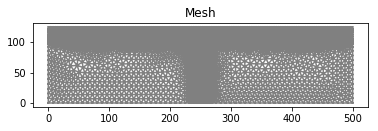

In [5]:
# Plot the mesh
plot(mesh,title='Mesh')
plt.show()

In [6]:
min_mesh_size = mesh.hmin()
print("Minimum mesh size:", min_mesh_size)

Minimum mesh size: 2.633498603971342


In [7]:
"""Material parameters."""

rho_ice = 917  # density of ice (kg/m^3)
rho_H2O = 1020  # density of seawater (kg/m^3)
grav = 9.81  # gravity acceleration (m/s**2)
temp = -10 + 273  # temperature (K)
B0 = 2.207e-3  # viscosity coefficient (kPa * yr**(1/3))
B0 *= 1e3  # convert to (Pa * yr**(1/3))
B0 *= (365*24)**(1/3)  # convert to (Pa * hour**(1/3))
BT = B0*np.exp(3155/temp - 0.16612/(273.39 - temp)**1.17)


In [8]:
"""Damage parameters."""

alpha = 0.21  # weight of max principal stress  in Hayhurst criterion
beta = 0.63  # weight of von Mises stress in Hayhurst criterion
r = 0.43  # damage exponent
B = 5.232e-7  # damage coefficient
k1, k2 = -2.63, 7.24  # damage rate dependency parameters
Dcr = 0.6  # critical damage
Dmax = 0.99  # maximum damage
lc = 10  # nonlocal length scale
# prec_ratio = 0.08
hs_ratio = 0 # water level in crevasse (normalized with crevasse height)
hw_ratio = 0 # water level at right terminus (normalized with glacier thickness)
prec_ratio = 0.08 # depth of pre-crack (

In [9]:
"""Set simulation time and timestepping options."""

t_total = 480  # total time (hours)
t_elapsed = 0  # current elapsed time (hours)
t_delay_dmg = 0  # delay damage (hours)
max_Delta_t = 2  # max time increment (For dmage set to 0.5 hours)
max_Delta_D = 0.1  # max damage increment
output_increment = 10  # number of steps between output
time_counter = 0  # current time step

In [10]:

"""Mesh details."""
# L, H = 500, 125  # domain dimensions
hs = 0  # water level in crevasse (normalized with crevasse height)
hw = 0  # water level at terminus (absolute height)
# mesh = load_mesh(output_dir + "mesh/hdf5/notch.h5")
# nd = mesh.geometry().dim()  # mesh dimensions (2D or 3D)

In [11]:
"""Define function spaces."""
S1 = FunctionSpace(mesh, "CG", 1)  # first order scalar space
S2 = FunctionSpace(mesh, "CG", 2)  # second order scalar space
V1 = VectorFunctionSpace(mesh, "CG", 1)  # first order vector space
V2 = VectorFunctionSpace(mesh, "CG", 2)  # second order vector space
P1 = FiniteElement("CG", mesh.ufl_cell(), 1)  # first order scalar element
P2 = VectorElement("CG", mesh.ufl_cell(), 2)  # second order vector element
V = FunctionSpace(mesh, MixedElement([P2, P1]))  # mixed finite element

In [12]:
"""Coordinates of nodes on initial mesh configuration."""
X1, X2 = S1.tabulate_dof_coordinates().reshape((-1, nd)).T  # coordinates
n_local = len(X1)  # number of coordinates on local process
n_global = S1.dim()  # number of coordinates in global system

In [13]:
L,H= max(X1),max(X2) 

In [14]:
def mwrite(filename, my_list):
    MPI.barrier(comm)
    if rank == 0:
        with open(filename, "w") as f:
            for item in my_list:
                f.write("%s" % item)


def mprint(*argv):
    if rank == 0:
        out = ""
        for arg in argv:
            out = out + str(arg)
        # this forces program to output when run in parallel
        print(out, flush=True)


In [15]:
mprint("Number of vertices      : {}".format(S1.dim()))
mprint("Number of cells         : {}".format(V1.dim()))
mprint("Number of DoF           : {}".format(V1.dim()))
mprint("Number of processes     : {}".format(size))
mprint("Number of DoF/process   : {}".format(int(V.dim() / size)))
mprint("-----------------------------------------------------")

Number of vertices      : 3611
Number of cells         : 7222
Number of DoF           : 7222
Number of processes     : 1
Number of DoF/process   : 31929
-----------------------------------------------------


In [16]:
class left_edge(SubDomain):
    """Boundary on the left domain edge."""
    def inside(self, x, on_boundary): return near(x[0], 0) and on_boundary


class right_edge(SubDomain):
    """Boundary on the right domain edge."""
    def inside(self, x, on_boundary): return near(x[0], L) and on_boundary


class bottom_edge(SubDomain):
    """Boundary on the bottom domain edge."""
    def inside(self, x, on_boundary): return near(x[1], 0) and on_boundary


class top_edge(SubDomain):
    """Boundary on the top domain edge."""
    def inside(self, x, on_boundary): return near(x[1], H) and on_boundary


""" Define boundaries and boundary conditions. """

left = left_edge()
right = right_edge()
bottom = bottom_edge()
top = top_edge()

boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
bottom.mark(boundaries, 3)
top.mark(boundaries, 4)
ds = Measure("ds", subdomain_data=boundaries)

free_slip_left = DirichletBC(V.sub(0).sub(0), Constant(0), left)
free_slip_bottom = DirichletBC(V.sub(0).sub(1), Constant(0), bottom)
BC = [free_slip_left, free_slip_bottom]

In [17]:
"""define functions that are required to solve the problem"""

def bodyforce(dmg, y, h=0):
    """Gravity loading as a body force. Fully failed points have
        no density unless they are filled with water. Then they
        have the same density as water.
    """
    Dcr = 0.6
    b = Function(V1)  # body force as vector function
    by = Function(S1)  # y-component of vector function
    for i in range(n_local):
        if dmg.vector()[i] < Dcr:
            by.vector()[i] = -rho_ice*grav
        if (dmg.vector()[i] >= Dcr)*(y[i] <= h):
            by.vector()[i] = -rho_H2O*grav
    assign(b.sub(1), by)
    return b

def hydrostatic(h):
    h_expression = Expression(("(h - x[1] > 0 ?-rho_H2O * grav*(h - x[1]) : 0)",0), h=hw, rho_H2O=rho_H2O, grav=grav, degree=1)
    return h_expression

def pore_pressure(dmg, x, y, h):
	"""Hydraulic pressure from poro-mechanics formulation."""
	Dcr = 0.6
	b_poro = Function(S1)
	dmg_local = dmg.vector().get_local()
	for i in range(n_local):
		if dmg_local[i] >= Dcr:
			b_poro.vector()[i] = rho_H2O*grav*np.fmax(h - y[i], 0)*dmg_local[i]
	return b_poro


def surface_crevasse_level(dmg, y, hsr, pr):
    """dynamically compute water level in the surface crevasse"""
    crevasse_depth = 0
    crevasse_surface = 0
    if hsr > 0:
        for i in range(n_local):  # Fix: Use 'range' and correct the syntax
            if dmg.vector()[i] > Dcr:
                x2_dmg = y[i]
                if len(x2_dmg) > 0:
                    x2_dmg_local_max = min(max(x2_dmg), H)
                    x2_dmg_local_min = max(min(x2_dmg), 0)
                else:
                    x2_dmg_local_max = H
                    x2_dmg_local_min = 0
                x2_dmg_max = comm.allreduce(x2_dmg_local_max, op=MPI.MAX)
                x2_dmg_min = comm.allreduce(x2_dmg_local_min, op=MPI.MIN)
                crevasse_depth = float(x2_dmg_max - x2_dmg_min)
                crevasse_surface = crevasse_depth * hsr + x2_dmg_min
    return crevasse_depth, crevasse_surface


In [18]:
"""Define constitutive and kinematic relationships."""


def D(u):
    """Symmetric gradient operator."""
    return sym(nabla_grad(u))


def DII(u):
    """Second strain invariant."""
    return (0.5*(D(u)[0, 0]**2 + D(u)[1, 1]**2) + D(u)[0, 1]**2)


def eta1(u, n=3, gam=1e-14):
    """Nonlinear viscosity."""
    return 0.5*BT*(DII(u) + gam)**((1 - n)/2/n)


def np_array(x):
    """converts x in to a vector format computed at the nodes"""
    return x.vector().get_local()


def mac(x):
    """Macaulay's bracket"""
    return (x+abs(x))/2


In [19]:
"""Initial guess for Picard iterations."""

uk = Function(V2)  # velocity
pk = Function(S1)  # pressure
dmg = Function(S1)
comm.Barrier()


In [20]:

"""Main time loop."""
#t_total t_elapsed
while t_elapsed < t_total:

    time_counter += 1
    # get current configuration coordinates
    x1, x2 = S1.tabulate_dof_coordinates().reshape((-1, nd)).T
    
    """Extract coordinates infor."""
    L,H= max(x1),max(x2) 
    n_local = len(x1)  # number of coordinates on local process
    n_global = S1.dim()  # number of coordinates in global system


    u, p = TrialFunctions(V)  # trial functions in (V2, S1) space
    v, q = TestFunctions(V)  # test functions in (V2, S1) space

    # hydraulic pressure in surface crevasse
    cdepth, csurfx2 = surface_crevasse_level(dmg=dmg, y=x2, hsr=hs_ratio, pr=prec_ratio)  # height of water column
    b_poro = pore_pressure(dmg=dmg, x=x1, y=x2, h=csurfx2)  # hydraulic pressure


    # define loading terms
    b_grav = bodyforce(dmg=dmg, y=x2, h=csurfx2) # gravity for ice and water
    b_hw = hydrostatic(h=hw)  # terminus pressure

    # normal function to mesh
    nhat = FacetNormal(mesh)

  # incompressibility terms
    penalty = False
     
    ### update degradation function with damage value from previous step

    # define variational form
    LHS = (inner(D(v), 2*eta1(uk)*D(u)) - div(v)*p
           + q*div(u))*dx
    if penalty:
        LHS += 1e12*inner(nabla_div(u), psi*div(v))*dx  # penalty term
        
    RHS = inner(v, b_grav)*dx  # ice and water gravity
    
    if hs > 0:
        RHS += inner(nabla_div(v), b_poro)*dx  # hydraulic pressure in damage zone
    if hw > 0:
        RHS += inner(v, b_hw)*ds(2)  # terminus pressure
        
    """ Picard iterations. """

    eps_local = 1  # local error norm
    eps_global = 1  # global error norm
    tol = 1e-4  # error tolerance
    picard_count = 0  # iteration count
    picard_max = 50  # maximum iterations
    w = Function(V)  # empty function to dump solution

    while (abs(eps_global) > tol) and (picard_count < picard_max):

        # solve the variational form
        solve(LHS == RHS, w, BC)
        u, p = w.split(deepcopy=True)
        u1, u2 = u.split(deepcopy=True)

        # compute error norms
        u1k, u2k = uk.split(deepcopy=True)
        diff1 = u1.vector().get_local() - u1k.vector().get_local()
        diff2 = u2.vector().get_local() - u2k.vector().get_local()
        diffp = p.vector().get_local() - pk.vector().get_local()
        eps1 = np.linalg.norm(diff1)/np.linalg.norm(u1.vector().get_local())
        eps2 = np.linalg.norm(diff2)/np.linalg.norm(u2.vector().get_local())
        epsp = np.linalg.norm(diffp)/np.linalg.norm(p.vector().get_local())

        # update solution for next iteration
        assign(uk, u)
        assign(pk, p)

        comm.Barrier()

        # obtain the max error on the local process
        eps_local = max(eps1, eps2, epsp)
        # obtain the max error on all processes
        eps_global = comm.allreduce(eps_local, op=MPI.max)


        # update iteration count
        picard_count += 1
        
    # build effective deviatoric stress tensor
    tau = 2*eta1(u)*D(u)
    t11 = project(tau[0, 0], S1).vector().get_local()
    t22 = project(tau[1, 1], S1).vector().get_local()
    t33 = np.zeros(n_local)
    t12 = project(tau[0, 1], S1).vector().get_local()

    dmg0 = dmg.vector().get_local()# damage from previous time step
    prs = interpolate(p, S1).vector().get_local()# effective pressure

    t23 = np.zeros(n_local)

    t13 = np.zeros(n_local)

 
    # effective Cauchy stress
    s11, s22, s33, s12, s23, s13 = t11 - prs, t22 - prs, t33 - prs, t12, t23, t13
    
    I1 = s11 + s22 + s33  # effective I1 invariant
    I1_true = (1 - dmg0)*I1 - 3*b_poro.vector().get_local()  # true I1 invariant

    J2 = 0.5*(t11**2 + t22**2 + t33**2) + t12**2  # effective J2 invariant
    vms = np.sqrt(3*J2)  # effective von Mises stress

    lam1 = s33
    lam2 = 0.5*(s11 + s22 + np.sqrt(s11**2 - 2*s11*s22 + 4*(s12**2) + s22**2))
    mps = np.fmax(lam1, lam2)  # effective max principal stress

    # effective Hayhurst stress
    chi = alpha*mps + beta*vms + (1 - alpha - beta)*I1

    """ Output data to mesh file. """

    Delta_t = max_Delta_t # time step = 0.5 hours ( for only Stoke, can set time step to any number)
    """ Save data """
    
    N11 = Function(S1, name="S11") # Normal stress
    H11 = Function(S1, name="H11") # Hayhurst stress
    V11 = Function(S1, name="V11") # von Mises stress
    P11 = Function(S1, name="P11") # max principal stress
    
    # Assuming s11, chi, and vms are NumPy arrays or similar
    N11.vector()[:] = s11
    H11.vector()[:] = chi
    V11.vector()[:] = vms
    P11.vector()[:] = mps

#     Write the data
    xdmf.write(N11, t_elapsed)
    xdmf.write(V11, t_elapsed)
    xdmf.write(H11, t_elapsed)
    xdmf.write(P11, t_elapsed)
    
    """ Updated Lagrangian implementation. """

    # split velocity into components in S1 space
    u1, u2 = u.split(deepcopy=True)
    u1 = interpolate(u1, S1).vector().get_local()
    u2 = interpolate(u2, S1).vector().get_local()

    # compute the displacement increment vector Delta_u
    Delta_u1 = Function(S1)
    Delta_u2 = Function(S1)
    Delta_u1.vector()[:] = u1*Delta_t
    Delta_u2.vector()[:] = u2*Delta_t

    Delta_u = Function(V1)
    assign(Delta_u.sub(0), Delta_u1)
    assign(Delta_u.sub(1), Delta_u2)
    
    # move the mesh, update coordinates
    ALE.move(mesh, Delta_u)

    # update elapsed time
    t_elapsed += Delta_t

    print("Time: %0.2f" % (t_elapsed))


Time: 2.00
Time: 4.00
Time: 6.00
Time: 8.00
Time: 10.00
Time: 12.00
Time: 14.00
Time: 16.00
Time: 18.00
Time: 20.00
Time: 22.00
Time: 24.00
Time: 26.00
Time: 28.00
Time: 30.00
Time: 32.00
Time: 34.00
Time: 36.00
Time: 38.00
Time: 40.00
Time: 42.00
Time: 44.00
Time: 46.00
Time: 48.00
Time: 50.00
Time: 52.00
Time: 54.00
Time: 56.00
Time: 58.00
Time: 60.00
Time: 62.00
Time: 64.00
Time: 66.00
Time: 68.00
Time: 70.00
Time: 72.00
Time: 74.00
Time: 76.00
Time: 78.00
Time: 80.00
Time: 82.00
Time: 84.00
Time: 86.00
Time: 88.00
Time: 90.00
Time: 92.00
Time: 94.00
Time: 96.00
Time: 98.00
Time: 100.00
Time: 102.00
Time: 104.00
Time: 106.00
Time: 108.00
Time: 110.00
Time: 112.00
Time: 114.00
Time: 116.00
Time: 118.00
Time: 120.00
Time: 122.00
Time: 124.00
Time: 126.00
Time: 128.00
Time: 130.00
Time: 132.00
Time: 134.00
Time: 136.00
Time: 138.00
Time: 140.00
Time: 142.00
Time: 144.00
Time: 146.00
Time: 148.00
Time: 150.00
Time: 152.00
Time: 154.00
Time: 156.00
Time: 158.00
Time: 160.00
Time: 162.00
